Load Library

In [ ]:
! pip install seaborn

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression

Load Data

In [40]:
df_hc = pd.read_csv('healthcare_dataset.csv')

df_hc.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


Data Analysis

In [41]:
df_hc["Medical Condition"].value_counts()

Medical Condition
Arthritis       9308
Diabetes        9304
Hypertension    9245
Obesity         9231
Cancer          9227
Asthma          9185
Name: count, dtype: int64

In [43]:
results = df_hc[['Gender', 'Age']].groupby('Gender').median().reset_index()

results

,Gender,Age
0,Female,52.0
1,Male,52.0


C:\Users\josh2\AppData\Local\Temp\ipykernel_2416\922265248.py:9: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  ax.boxplot(hist_data, 0, '', vert=False)


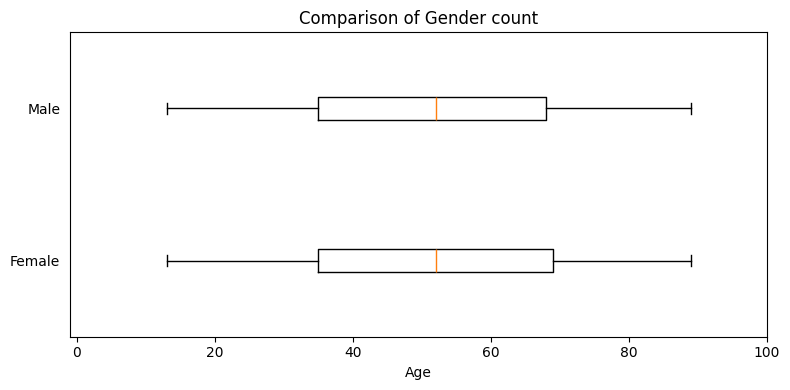

In [44]:
results = df_hc[['Gender', 'Age']].groupby('Gender').median().reset_index()
categories = results['Gender'].values.tolist()

hist_data = []
for cat in categories:
    hist_data.append(df_hc['Age'].loc[df_hc['Gender']==cat].values)

fig, ax = plt.subplots(figsize=(8,4))
ax.boxplot(hist_data, 0, '', vert=False)
ax.set_xlim((-1, 100))
ax.set_yticklabels(categories)
ax.set_xlabel('Age')
ax.tick_params(left=False, right=False)
ax.set_title('Comparison of {} count'.format('Gender'))
plt.tight_layout()
plt.show()

In [45]:
insurance_gender = df_hc.groupby(['Insurance Provider', 'Gender']).value_counts().reset_index(name='Count')

Text(0, 0.5, 'Count')

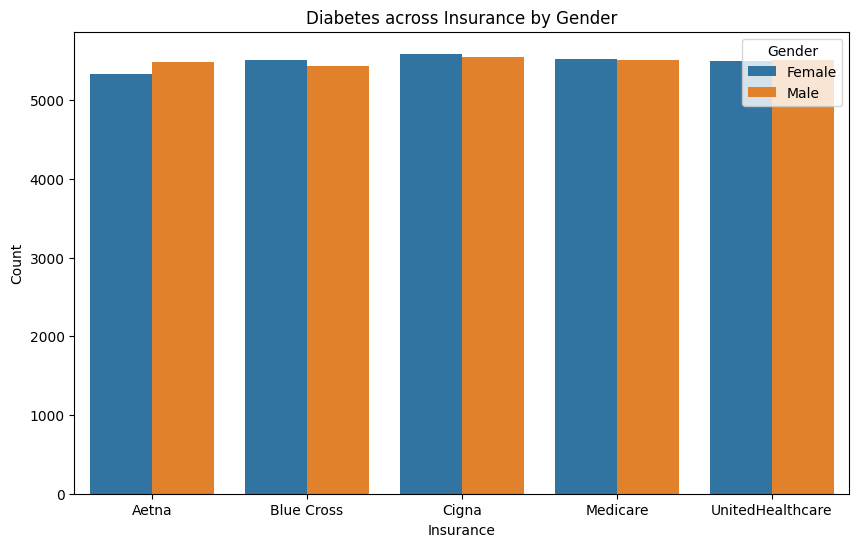

In [46]:
# Create a complex visualization
plt.figure(figsize=(10, 6))
sns.countplot(data=insurance_gender, x='Insurance Provider', hue='Gender')
plt.title("Diabetes across Insurance by Gender")
plt.xlabel("Insurance")
plt.ylabel("Count")


In [47]:
df_hc_diabetes = df_hc[df_hc["Medical Condition"] == "Diabetes"]
df_hc_diabetes.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
6,edwArD EDWaRDs,21,Female,AB-,Diabetes,2020-11-03,Kelly Olson,Group Middleton,Medicare,19580.872345,389,Emergency,2020-11-15,Paracetamol,Inconclusive
12,connOR HANsEn,75,Female,A+,Diabetes,2019-12-12,Kenneth Fletcher,"Powers Miller, and Flores",Cigna,43282.283358,134,Emergency,2019-12-28,Penicillin,Abnormal
27,mr. KenNEth MoORE,34,Female,A+,Diabetes,2022-06-21,James Ellis,Serrano-Dixon,UnitedHealthcare,18834.801341,157,Emergency,2022-06-30,Lipitor,Abnormal
34,NicOlE RodriGUEz,30,Female,AB+,Diabetes,2020-01-17,Lynn Young,Poole Inc,Blue Cross,8408.949354,285,Emergency,2020-02-10,Lipitor,Normal


In [81]:
df_hc_diabetes["LOS"] = (pd.to_datetime(df_hc_diabetes["Discharge Date"]) - pd.to_datetime(df_hc_diabetes["Date of Admission"])).dt.total_seconds()/86400
df_hc_diabetes["LOS"].describe()

count    9304.000000
mean       15.422936
std         8.656565
min         1.000000
25%         8.000000
50%        15.000000
75%        23.000000
max        30.000000
Name: LOS, dtype: float64

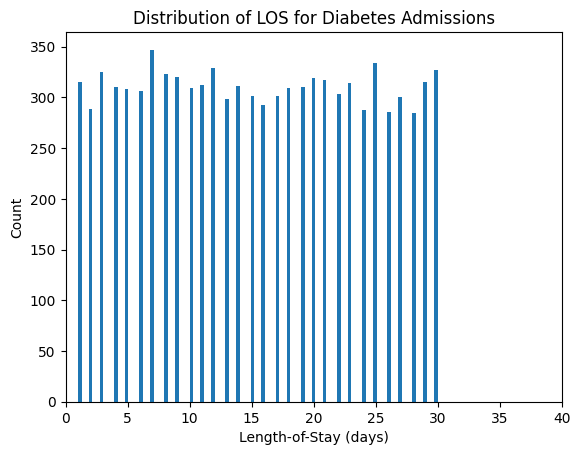

In [49]:
# Plot LOS Distribution
plt.hist(df_hc_diabetes['LOS'], bins=100)
plt.xlim(0, 40)
plt.title('Distribution of LOS for Diabetes Admissions')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False)
plt.show();

(1.0, 50.0)

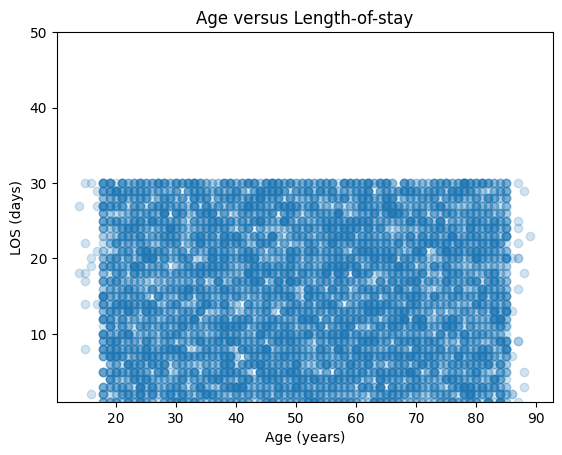

In [50]:
plt.scatter(df_hc_diabetes['Age'], df_hc_diabetes['LOS'],  alpha=0.2)
#plt.yscale('sqrt')
plt.ylabel('LOS (days)')
plt.xlabel('Age (years)')
plt.title('Age versus Length-of-stay')
plt.ylim(1, 50)

Model Comparision

In [52]:
df_hc.drop(columns=['Name', 'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider', 'Billing Amount', 
                    'Room Number', 'Admission Type', 'Discharge Date', 'Medication'], inplace=True)

In [53]:
# Create dummy columns for categorical variables
prefix_cols = ['gender', 'Blood_Type', 'Medical_Condition', 'Test_Results']
dummy_cols = ['Gender', 'Blood Type', 'Medical Condition', 'Test Results']
df_hc = pd.get_dummies(df_hc, prefix=prefix_cols, columns=dummy_cols)
df_hc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Age                             55500 non-null  int64
 1   gender_Female                   55500 non-null  bool 
 2   gender_Male                     55500 non-null  bool 
 3   Blood_Type_A+                   55500 non-null  bool 
 4   Blood_Type_A-                   55500 non-null  bool 
 5   Blood_Type_AB+                  55500 non-null  bool 
 6   Blood_Type_AB-                  55500 non-null  bool 
 7   Blood_Type_B+                   55500 non-null  bool 
 8   Blood_Type_B-                   55500 non-null  bool 
 9   Blood_Type_O+                   55500 non-null  bool 
 10  Blood_Type_O-                   55500 non-null  bool 
 11  Medical_Condition_Arthritis     55500 non-null  bool 
 12  Medical_Condition_Asthma        55500 non-null  bool 
 13  M

In [54]:
# Hospital LOS metrics for later comparison
actual_mean_diabetes = df_hc['Medical_Condition_Diabetes'].mean()
actual_median_diabetes = df_hc['Medical_Condition_Diabetes'].median()

print(actual_mean_diabetes)
print(actual_median_diabetes)

0.16763963963963963
0.0


In [55]:
df_hc.head()

,Age,gender_Female,gender_Male,Blood_Type_A+,Blood_Type_A-,Blood_Type_AB+,Blood_Type_AB-,Blood_Type_B+,Blood_Type_B-,Blood_Type_O+,Blood_Type_O-,Medical_Condition_Arthritis,Medical_Condition_Asthma,Medical_Condition_Cancer,Medical_Condition_Diabetes,Medical_Condition_Hypertension,Medical_Condition_Obesity,Test_Results_Abnormal,Test_Results_Inconclusive,Test_Results_Normal
0,30,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True
1,62,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False
2,76,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
3,28,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False
4,43,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False


In [56]:
# Target Variable (Length-of-Stay)
Diabetes = df_hc['Medical_Condition_Diabetes'].values
# Prediction Features
features = df_hc.drop(columns=['Medical_Condition_Diabetes'])

In [57]:
features

,Age,gender_Female,gender_Male,Blood_Type_A+,Blood_Type_A-,Blood_Type_AB+,Blood_Type_AB-,Blood_Type_B+,Blood_Type_B-,Blood_Type_O+,Blood_Type_O-,Medical_Condition_Arthritis,Medical_Condition_Asthma,Medical_Condition_Cancer,Medical_Condition_Hypertension,Medical_Condition_Obesity,Test_Results_Abnormal,Test_Results_Inconclusive,Test_Results_Normal
0,30,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True
1,62,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False
2,76,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True
3,28,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
4,43,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55495,42,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False
55496,61,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True
55497,38,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False
55498,43,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False


In [58]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    Diabetes,
                                                    test_size = .20,
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 44400 samples.
Testing set has 11100 samples.


In [59]:
# Regression models for comparison
models = [GradientBoostingRegressor(random_state = 0),
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results = {}

for model in models:

    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)

    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)

    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))

GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.
RandomForestRegressor done.


Text(0.5, 1.0, 'Comparison of Regression Models')

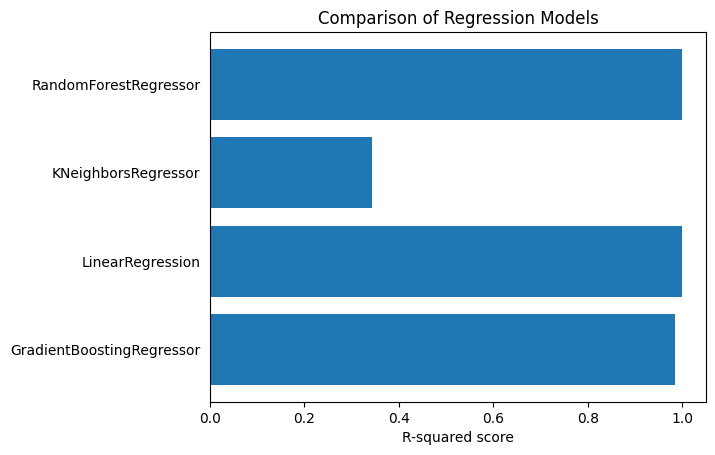

In [60]:
# R2 score results
fig, ax = plt.subplots()
ind = range(len(results))
ax.barh(ind, list(results.values()), align='center')
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False)
ax.set_title('Comparison of Regression Models')

In [61]:
# GradientBoostingRegressor will be used as the LOS prediction model
reg_model = GradientBoostingRegressor(random_state=0)
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
print("R2 score is: {:2f}".format(r2_not_refined))

R2 score is: 0.985306


In [62]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    Diabetes,
                                                    test_size = .20,
                                                    random_state = 50)

# Set the parameters by cross-validation
tuned_parameters = [{'n_estimators': [200, 300, 400],
                     'max_depth' : [2, 3, 4],
                     'loss': ['quantile', 'squared_error', 'absolute_error', 'huber']}]

# create and fit a ridge regression model, testing each alpha
reg_model = GradientBoostingRegressor()
grid = GridSearchCV(reg_model, tuned_parameters)
grid.fit(X_train, y_train)
reg_model_optimized = grid.best_estimator_

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

0.9999999999999986
GradientBoostingRegressor(loss='huber', max_depth=4, n_estimators=400)


In [63]:
y_test_preds = reg_model_optimized.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:2f}".format(r2_optimized))

Optimized R2 score is: 1.000000


In [64]:
print('Model refinement improved R2 score by {:.4f}'.format(r2_optimized-r2_not_refined))

Model refinement improved R2 score by 0.0147


In [82]:
feature_imp = pd.DataFrame(reg_model_optimized.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)

,importance
Medical_Condition_Cancer,2.122024e-01
Medical_Condition_Obesity,2.062521e-01
Medical_Condition_Asthma,2.016181e-01
Medical_Condition_Hypertension,1.955610e-01
Medical_Condition_Arthritis,1.843663e-01
Age,2.952754e-13
Test_Results_Abnormal,5.284018e-15
gender_Female,4.735424e-16
Test_Results_Normal,4.327176e-16
gender_Male,2.605256e-16


In [83]:
feature_imp.index[0:10].tolist()

['Medical_Condition_Cancer',
 'Medical_Condition_Obesity',
 'Medical_Condition_Asthma',
 'Medical_Condition_Hypertension',
 'Medical_Condition_Arthritis',
 'Age',
 'Test_Results_Abnormal',
 'gender_Female',
 'Test_Results_Normal',
 'gender_Male']

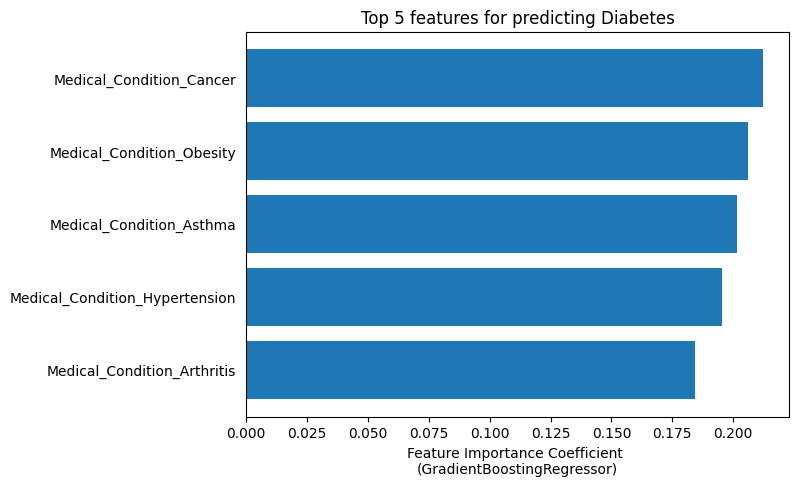

In [86]:
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,5)
ax.barh(ind, feature_imp['importance'].values[0:5], align='center')
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:5].tolist())
ax.tick_params(left=False, top=False, right=False)
ax.set_title("Top 5 features for predicting Diabetes")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()

Prediction Model days 1.0072170069397554e-08
Median Model days 0.16423423423423422
Average Model days 0.27680953818685355
Prediction Model RMS 7.878508923053206e-05
Median Model RMS 9.353646539966573e-05
Average Model RMS 9.345263706575915e-05


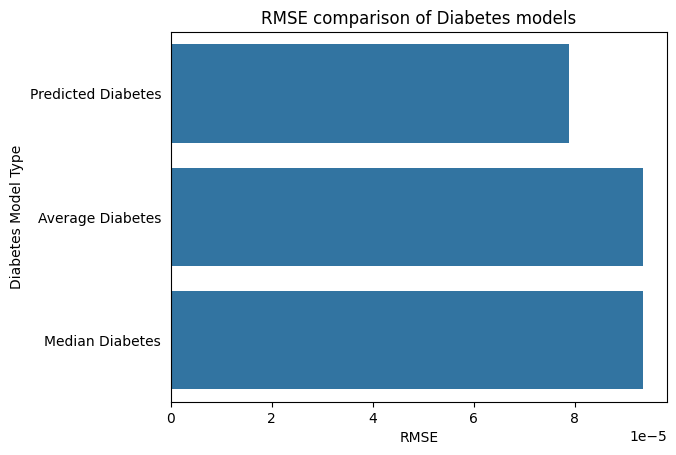

In [80]:
actual_avg_diabetes = df_hc['Medical_Condition_Diabetes'].mean()
ml_count, md_count, avg_count = 0, 0, 0
ml_days, md_days, avg_days = 0, 0, 0
ml_days_rms, md_days_rms, avg_days_rms = 0, 0, 0

for i in range(y_test_preds.shape[0]):
    ml_model = abs(y_test_preds[i] - y_test[i])
    median_model = abs(actual_median_diabetes - y_test[i])
    average_model = abs(actual_avg_diabetes - y_test[i])

    ml_days += ml_model
    md_days += median_model
    avg_days += average_model

    ml_model_rms = (y_test_preds[i] - y_test[i]) ** 2
    median_model_rms = (actual_median_diabetes - y_test[i]) ** 2
    average_model_rms = (actual_avg_diabetes - y_test[i]) ** 2

    ml_days_rms += ml_model_rms
    md_days_rms += median_model_rms
    avg_days_rms += average_model_rms

print("Prediction Model days {}".format(ml_days / y_test_preds.shape[0]))
print("Median Model days {}".format(md_days / y_test_preds.shape[0]))
print("Average Model days {}".format(avg_days / y_test_preds.shape[0]))

print("Prediction Model RMS {}".format((ml_days_rms ** 0.005) / y_test_preds.shape[0]))
print("Median Model RMS {}".format((md_days_rms ** 0.005) / y_test_preds.shape[0]))
print("Average Model RMS {}".format((avg_days_rms ** 0.005) / y_test_preds.shape[0]))
# RMSE plot for writeup
data = pd.DataFrame({'RMSE': [(ml_days_rms**0.005)/y_test_preds.shape[0],
                             (avg_days_rms**0.005)/y_test_preds.shape[0],
                             (md_days_rms**0.005)/y_test_preds.shape[0]],
                     'Diabetes Model Type': ['Predicted Diabetes', 'Average Diabetes', 'Median Diabetes'] })

fig, ax = plt.subplots()
ax = sns.barplot(x='RMSE', y='Diabetes Model Type', data=data)
ax.set_title('RMSE comparison of Diabetes models')
ax.tick_params(top=False, left=False, right=False)

plt.show()